In [1]:
import pandas as pd
import geopandas as gpd

# Import

In [2]:
# Import Geopackages
VeloWege = gpd.read_file(r'data/Velo_wege.gpkg', crs = "epsg:2056")
Unfaelle = gpd.read_file(r'data/RoadTrafficAccidentLocations.gpkg', crs = "epsg:2056")

In [3]:
# Import CSV
VerkehrsZaehlung = pd.read_csv(r'data/2021_verkehrszaehlungen_werte_fussgaenger_velo.csv')

# Turn it into a GeoDataFrame with point geometries
Zaehlungen = gpd.GeoDataFrame(
    VerkehrsZaehlung, geometry=gpd.points_from_xy(VerkehrsZaehlung.OST, VerkehrsZaehlung.NORD), crs = "epsg:2056")

## EDA
1: First, we will conduct an EDA on all three data-sets to get a feeling for the data


<AxesSubplot:>

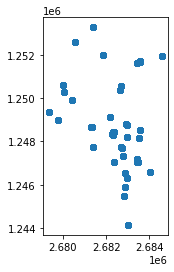

In [4]:
Zaehlungen.plot()

In [5]:
Zaehlungen.head(3)

,FK_ZAEHLER,FK_STANDORT,DATUM,VELO_IN,VELO_OUT,FUSS_IN,FUSS_OUT,OST,NORD,geometry
0,U15G3063865,1357,2021-01-01T00:00,NaN,NaN,20.0,0.0,2682973,1246329,POINT (2682973.000 1246329.000)
1,ECO09113499,3927,2021-01-01T00:00,0.0,3.0,NaN,NaN,2682873,1245891,POINT (2682873.000 1245891.000)
2,U15G3063867,1358,2021-01-01T00:00,NaN,NaN,4.0,1.0,2683557,1251702,POINT (2683557.000 1251702.000)


<AxesSubplot:>

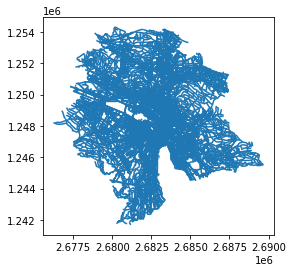

In [6]:
VeloWege.plot()

In [7]:
VeloWege.head(3)

,id1,velo,velostreifen,veloweg,einbahn,fuss,name,map_velo,map_fuss,se_anno_cad_data,objectid,geometry
0,137,0,0,0,0,1,"Bahnhof Oerlikon, Perron Gleis 6",0,0,b'',1.0,"LINESTRING (2683427.088 1251829.395, 2683455.0..."
1,138,0,0,0,0,0,Bahnhofstrasse,0,0,b'',2.0,"LINESTRING (2683164.177 1247919.613, 2683164.9..."
2,139,1,0,0,0,0,Zwischenbächen,1,0,b'',3.0,"LINESTRING (2678697.201 1248708.631, 2678677.6..."


<AxesSubplot:>

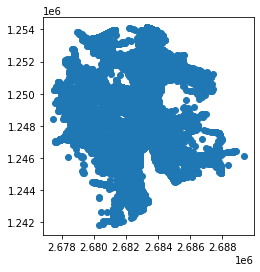

In [8]:
Unfaelle.plot()

In [9]:
# Filter to only contain Accidents involving Bikes
VeloUnfaelle = Unfaelle.loc[Unfaelle['AccidentInvolvingBicycle']==True]

In [10]:
VeloUnfaelle.head(3)

,AccidentUID,AccidentType,AccidentType_de,AccidentType_fr,AccidentType_it,AccidentType_en,AccidentSeverityCategory,AccidentSeverityCategory_de,AccidentSeverityCategory_fr,AccidentSeverityCategory_it,...,AccidentMonth_it,AccidentMonth_en,AccidentWeekDay,AccidentWeekDay_de,AccidentWeekDay_fr,AccidentWeekDay_it,AccidentWeekDay_en,AccidentHour,AccidentHour_text,geometry
1,9FD6441F802C20A6E0430A865E3320A6,at0,Schleuder- oder Selbstunfall,dérapage ou perte de maîtrise,Incidente di sbandamento o per colpa propria,Accident with skidding or self-accident,as3,Unfall mit Leichtverletzten,accident avec blessés légers,Incidente con feriti leggeri,...,Gennaio,January,aw406,Samstag,samedi,Sabato,Saturday,1.0,01h-02h,POINT (2682382.000 1246980.000)
9,9FDA0D984DA49018E0430A865E339018,at8,Fussgängerunfall,accident impliquant des piétons,Incidente con pedoni,Accident involving pedestrian(s),as2,Unfall mit Schwerverletzten,accident avec blessés graves,Incidente con feriti gravi,...,Gennaio,January,aw406,Samstag,samedi,Sabato,Saturday,15.0,15h-16h,POINT (2683238.000 1246773.000)
19,9FC2F14A65F30050E0430A865E330050,at3,Abbiegeunfall,accident en quittant une route,Incidente nello svoltare,Accident when turning left or right,as3,Unfall mit Leichtverletzten,accident avec blessés légers,Incidente con feriti leggeri,...,Gennaio,January,aw401,Montag,lundi,Lunedí,Monday,8.0,08h-09h,POINT (2681179.000 1247560.000)


#### EDA Conclusions
- we have all data in LV95 (epsg:2056)
    - this is good for analysis. if we face problems with visualizing in the end, we can use the following pyproj transformer to project it into WGS84 webmercator
- the Zaehlungen set is quite large (beacause of it's huge time dimension), we need to work smart with it and not do loops on it
- the Unfaelle have to be filtered! To only include the bicycle ones.
- we know which LineStrings are oneway streets.... but all bicyclists are criminals, so that dosen't matter ;)

In [11]:
# Convert Coordinate Columns from LV95 to WGS84
# from pyproj import Transformer
#
# CHtoWGS = Transformer.from_crs("epsg:2056", "epsg:4326")
# df['Longitude'], df['Latitude'] = CHtoWGS.transform(df['OST'], df['NORD'])
#
# --> Everything is in epsg:2056, we might only need to transform into WebMercator for visualization

## Segmentation
2: We segment the bicycle path network into nodes and edges
- **Not needed! The path network is already segmented :)**
    - It contains "edges only" - it is split at every node
- Checked the gpkg in QGIS, easy to see

## Attribute Accidents to Edges (Line Segments). 
Accidents get also attributed by severity of the accident (categories already set by raw data)<br>
- Goal: gdf with Edges and geographically matched incident attributes
    - We need to think about how this should look like. 
        - Do we need to keep the single accidents? 
        - Should we summarize only geographically and get rid of time? <br>
--> add id1 from VeloWege to accidents

#### There is a Funciton in Shapley for the reverse (closest Point to Line)
But that dosen't help us, as we would get multiple matches

In [12]:
from shapely.ops import nearest_points
from shapely.geometry import LineString, Point
p = Point(11,8)  # geometry1
line = LineString([(0, 0), (5, 7), (12, 6)])  # geometry2
p2 = nearest_points(line, p)[0]
print(p2)  # POINT (5 7)

POINT (10.74 6.18)


So we kept on looking, finding a method to search for closest lines!

#### This works... 
https://gis.stackexchange.com/questions/81613
... but is way to slow

In [13]:
from shapely.geometry import Point, LineString, mapping, shape
from shapely.ops import cascaded_union
from shapely import affinity


def ClosestLine(point, line_gdf):
    
    sweep_res = 20  # sweep resolution (degrees)
    focal_pt = point  # radial sweep centre point
    sweep_radius = 100.0  # sweep radius

    # create the radial sweep lines
    line = LineString([(focal_pt.x,focal_pt.y), \
                    (focal_pt.x, focal_pt.y + sweep_radius)])

    sweep_lines = [affinity.rotate(line, i, (focal_pt.x, focal_pt.y)) \
                for i in range(0, 360, sweep_res)]

    radial_sweep = cascaded_union(sweep_lines)

    # load the input lines and combine them into one geometry
    # input_lines = line_gdf.geometry #fiona.open("input_lines.shp")
    input_shapes = line_gdf.geometry  #[shape(f['geometry']) for f in input_lines]
    all_input_lines = cascaded_union(input_shapes)

    perimeter = []
    # traverse each radial sweep line and check for intersection with input lines
    for radial_line in radial_sweep:
        inter = radial_line.intersection(all_input_lines)

        if inter.type == "MultiPoint":
        # radial line intersects at multiple points
            inter_dict = {}
            for inter_pt in inter:
                inter_dict[focal_pt.distance(inter_pt)] = inter_pt
        # save the nearest intersected point to the sweep centre point
            perimeter.append(inter_dict[min(inter_dict.keys())])

        if inter.type == "Point":
        # radial line intersects at one point only
            perimeter.append(inter)

        if inter.type == "GeometryCollection":
        # radial line doesn't intersect, so skip
            pass

    # combine the nearest perimeter points into one geometry
    solution = LineString(cascaded_union(perimeter))

    return solution

It is computationally also a very unelegant solution (considering the loops), therfore it takes super long too. Here an approximation in hours:

In [14]:
(len(VeloUnfaelle) / 5 * 70)/60/60
# it took 70s for 5 segments to process

23.298333333333336

### Let's try something else...

Goal: give every Accident the ID of the closest Road segment.
Idea: Point in Polygon; Voronoi for LineSegments

While working on this idea, we needed to split the lines into vertices to create the Voronoi cells, since there seems to be no good algorithm to create Voronoi cells from lines. The Iiea was to then merge all Voronoi cells (created with the vertices) which intersect with the orginal line to build a cell for the whole line segment. <br>
We used QGIS to split the lines in vertices, as it has a very efficent function for that: <br>
We show the ```QGIS Python code``` for reproducabillity. 

With QGIS:
- Load Lines gpkg
- Vector > Geometry Tools > Extract Vertices
    - ```processing.run("native:extractvertices", {'INPUT':'/home/linusrg/Code/Velo-Zueri/Velo-Zueri-Unfaelle/data/Velo_wege.gpkg|layername=taz_mm_tbl_routennetz|geometrytype=LineString','OUTPUT':'TEMPORARY_OUTPUT'}) ```
- Resulting in a temporary new Point Layer
- Vector > Geometry Tools > Voronoi Polygons
    - ```processing.run("qgis:voronoipolygons", {'INPUT':'memory://Point?crs=EPSG:2056&field=id:long(0,0)&field=id1:long(0,0)&field=velo:integer(0,0)&field=velostreifen:string(5,0)&field=veloweg:integer(0,0)&field=einbahn:string(5,0)&field=fuss:integer(0,0)&field=name:string(150,0)&field=map_velo:integer(0,0)&field=map_fuss:integer(0,0)&field=se_anno_cad_data:binary(0,0)&field=objectid:double(0,0)&field=vertex_index:integer(10,0)&field=vertex_part:integer(10,0)&field=vertex_part_index:integer(10,0)&field=distance:double(20,14)&field=angle:double(20,14)&uid={19c7245c-2773-410f-bd82-3fbf1fd3116f}','BUFFER':0,'OUTPUT':'TEMPORARY_OUTPUT'})```

But we realized, that the resulting Voronoi cells had some flaws. The algorithm drew some random huge cells over other cells. We could of course manully delete to big cells, but we wanted a cleaner approach. We realized that with QGIS it is posible to find the nearest point of another point. Which we can now do with the vertices of our Line Segments:

With QGIS again:
- We still have the temporary new Point Layer containing the Vertices of the Bike Network Line Segments.
- Vector > Analysis Tools > Distance Matrix...
    - ```processing.run("qgis:distancematrix", {'INPUT':'/home/linusrg/Code/Velo-Zueri/Velo-Zueri-Unfaelle/data/VeloUnfaelle.gpkg|layername=VeloUnfaelle','INPUT_FIELD':'AccidentUID','TARGET':'memory://memory?geometry=Point&crs=EPSG:2056&field=id:int8(0,0)&field=id1:int8(0,0)&field=velo:integer(0,0)&field=velostreifen:string(5,0)&field=veloweg:integer(0,0)&field=einbahn:string(5,0)&field=fuss:integer(0,0)&field=name:string(150,0)&field=map_velo:integer(0,0)&field=map_fuss:integer(0,0)&field=se_anno_cad_data:binary(0,0)&field=objectid:double(0,0)&field=vertex_index:integer(10,0)&field=vertex_part:integer(10,0)&field=vertex_part_index:integer(10,0)&field=distance:double(20,14)&field=angle:double(20,14)&uid={9918bfc2-204d-4ba5-8029-2cb852b1148f}','TARGET_FIELD':'id1','MATRIX_TYPE':0,'NEAREST_POINTS':1,'OUTPUT':'TEMPORARY_OUTPUT'})```
- We then exported the matrix as csv and import it here again:   

In [15]:
DistMatrix = pd.read_csv("data/DistanceMatrix.csv")
#InputID: VeloUnfaelle['AccidentUID']
#TargetID: VeloWege['id1']

DistMatrix.rename(columns = {'InputID':'AccidentUID', 'TargetID':'id1'}, inplace = True)

In [16]:
DistMatrix.head(3)

,AccidentUID,id1,Distance
0,9FD6441F802C20A6E0430A865E3320A6,1006,8.229085
1,9FDA0D984DA49018E0430A865E339018,3101,4.105777
2,9FC2F14A65F30050E0430A865E330050,6904,1.398630


#### Adding the LineSegment ID to the Accidents

In [17]:
VeloUnfaelle = pd.merge(VeloUnfaelle, DistMatrix, on="AccidentUID", how="inner")

#### Giving the Edges (our LineSegments) a weight


In [18]:
timeAx = sorted(VeloUnfaelle['AccidentHour'].unique())
timeAx = list(map(int, timeAx))
print(timeAx)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [20]:
wayAx = sorted(DistMatrix['id1'].unique())
wayAx = list(map(int, wayAx))

In [22]:
Weights = pd.DataFrame(0,
                    columns = timeAx,
                    index = wayAx)

In [23]:
Weights

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47512,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47513,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47827,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### The Weight - This is a hard ethical Question
We have four categories: as1 - somebody died, as2 - someone was heavily injured, as3 - someone was lightly injured, as4 - material damage only. Now we have to weigh those categories numerically. 

In [24]:
severityDict = {'as1': 4,'as2': 3, 'as3': 2, 'as4':1 }

In [25]:
VeloUnfaelle['SeverityWeight'] = VeloUnfaelle['AccidentSeverityCategory'].map(severityDict)

In [26]:
for way in wayAx:    
    for time in timeAx:
        Weights.at[way, time] = VeloUnfaelle.loc[(VeloUnfaelle['AccidentHour'] == time) & (VeloUnfaelle['id1'] == way), 'SeverityWeight'].sum()
# Not super elegant, but it only runs for ca 1min.

In [27]:
Weights

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
1,0,0,0,0,2,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,2,3,...,0,0,0,0,2,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
21,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47192,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
47512,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
47513,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47827,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0


## Normalization
4: Then, accidents normalized by the closest (determined via Voronoi tessellation) counting station value. 
The resulting graph of safety-weighted edges has an x, y and t (Lat, Long and Daytime) dimension. 

#### Further Plan:
- Downsample the Zaehlungen to hours only: get 24 rows for every hour.
- Create a mapping between LineSegment id1 and the Station. Via Voronoi and GPD line in Polygon?
- Multiply the weights with the corresponding normalization (Station and Hour) 

## Model
5: We will then use this graph to train a model (Maybe SVM, GCN or we will see what the lecture brings us).
The model should then be capable to predict the safety of any rout at any time in Zurich <br>
--> Well, we do not need a model to do that, we need an algorithm :)
https://pythonwife.com/dijkstras-algorithm-in-python/

In [28]:
#Initializing the Graph Class
from collections import defaultdict


class Graph:
    def __init__(self):
        self.nodes = set()
        self.edges = defaultdict(list)
        self.distances = {}
    
    def addNode(self,value):
        self.nodes.add(value)
    
    def addEdge(self, fromNode, toNode, distance):
        self.edges[fromNode].append(toNode)
        self.distances[(fromNode, toNode)] = distance

In [29]:
#Implementing Dijkstra's Algorithm
def dijkstra(graph, initial):
    visited = {initial : 0}
    path = defaultdict(list)

    nodes = set(graph.nodes)

    while nodes:
        minNode = None
        for node in nodes:
            if node in visited:
                if minNode is None:
                    minNode = node
                elif visited[node] < visited[minNode]:
                    minNode = node
        if minNode is None:
            break

        nodes.remove(minNode)
        currentWeight = visited[minNode]

        for edge in graph.edges[minNode]:
            weight = currentWeight + graph.distances[(minNode, edge)]
            if edge not in visited or weight < visited[edge]:
                visited[edge] = weight
                path[edge].append(minNode)
    
    return visited, path

In [50]:
customGraph = Graph()
customGraph.addNode("A")
customGraph.addNode("B")
customGraph.addNode("C")
customGraph.addNode("D")
customGraph.addNode("E")
customGraph.addNode("F")
customGraph.addNode("G")
customGraph.addEdge("A", "B", 2)
customGraph.addEdge("A", "C", 5)
customGraph.addEdge("B", "C", 6)
customGraph.addEdge("B", "D", 1)
customGraph.addEdge("B", "E", 3)
customGraph.addEdge("C", "F", 8)
customGraph.addEdge("D", "E", 4)
customGraph.addEdge("E", "G", 9)
customGraph.addEdge("F", "G", 7)

print(dijkstra(customGraph, "B"))

({'B': 0, 'C': 6, 'D': 1, 'E': 3, 'G': 12, 'F': 14}, defaultdict(<class 'list'>, {'C': ['B'], 'D': ['B'], 'E': ['B'], 'G': ['E'], 'F': ['C']}))


### Building the Graph

So we need vertices. We need to create them from our VeloWege gdf:

In [30]:
# Create a new column with start an endpoint as a MultiPoint object
VeloWege['boundary'] = VeloWege.geometry.boundary

In [31]:
# Function to split the MultiPoint Object into two points
# First try, didn't work as planed 
def getVertices(row):
    line = VeloWege['boundary'][row]
    first, last = line.boundary
    return(first, last)

In [39]:
# So we used string slicing :)
def getVerticesSlicer(wkt, position = "First"):
    string = str(wkt)
    if len(string) < 40:
        return "nein", "nein"
    elif position == "Last":
        list = string.split(", ")
        last = list[1].split(")")[0]
        return str(last)
    else:
        list = string.split(", ")
        first = list[0].split("(")[1]
        return str(first)

In [40]:
VeloWege['last'] = ""
VeloWege['first'] = ""

In [41]:
# apply function
VeloWege['last'] = VeloWege.apply(lambda row : getVerticesSlicer(row['boundary'].wkt, position = "Last"), axis = 1)
VeloWege['first'] = VeloWege.apply(lambda row : getVerticesSlicer(row['boundary'].wkt), axis = 1)

In [42]:
# Our unique Vertices
Vertices = pd.concat([VeloWege['last'], VeloWege['first']], axis = 0).unique()

Now we need to find all combinations and theire weights...


In [36]:
ZueriVelo = Graph()

In [45]:
#Add Vertices
for vertex in Vertices:
    if vertex == ('nein', 'nein'):
        continue
    else:
        ZueriVelo.addNode(vertex)

### Choose Time Here

In [79]:
time = 16

#Add Edges
for idx, row in Weights.iterrows():
    weight = Weights.loc[idx, time]
    first = VeloWege.loc[VeloWege['id1'] == idx, 'first'].item()
    last = VeloWege.loc[VeloWege['id1'] == idx, 'last'].item()
    print(idx, weight, first, last)
    customGraph.addEdge(first, last, weight)
    customGraph.addEdge(last, first, weight)


1 0 2681841.668 1247365.5918 2681695.8945 1247505.4781
6 0 2681871.752 1249415.1469 2681800.4855 1249433.7254
9 0 2687710.8059 1247037.571 2687873.114 1247186.3187
21 0 2681919.2004 1249614.6841 2681899.7865 1249629.1897
25 0 2683906.3708 1251948.8219 2683936.0249 1251950.4923
34 0 2682221.4482 1245739.4967 2682229.42 1245739.5417
35 0 2679592.2306 1248803.1492 2679681.4782 1248691.5865
36 0 2682561.8272 1250278.9095 2682561.9868 1250302.8939
46 0 2683079.9568 1249228.3765 2683081.3945 1249218.6434
47 0 2684903.8413 1246741.3106 2684963.2678 1246706.5328
57 0 2681990.8321 1247294.815 2682020.0652 1247304.8656
61 0 2685607.2 1250989.6205 2685624.028 1250984.1756
62 0 2682784.9601 1248364.3389 2682745.1405 1248394.6185
66 0 2682625.8971 1252681.5972 2682597.069 1252676.8536
68 0 2683669.8525 1251203.3301 2683673.5868 1251228.1711
73 0 2683302.311 1248059.0678 2683293.3789 1248087.372
83 0 2681760.0822 1247302.2809 2681695.6442 1247262.0156
87 2 2684657.7361 1246301.3908 2684722.9437 1246

In [74]:
Vertices[223]

'2684254.4116 1245865.78'

In [80]:
print(dijkstra(ZueriVelo, Vertices[223]))

({'2684254.4116 1245865.78': 0}, defaultdict(<class 'list'>, {}))


In [ ]:
VeloWege.head(3)

,id1,velo,velostreifen,veloweg,einbahn,fuss,name,map_velo,map_fuss,se_anno_cad_data,objectid,geometry,last,first,boundary
0,137,0,0,0,0,1,"Bahnhof Oerlikon, Perron Gleis 6",0,0,b'',1.0,"LINESTRING (2683427.088 1251829.395, 2683455.0...",2683455.051 1251844.5079,2683427.0882 1251829.3946,"MULTIPOINT (2683427.088 1251829.395, 2683455.0..."
1,138,0,0,0,0,0,Bahnhofstrasse,0,0,b'',2.0,"LINESTRING (2683164.177 1247919.613, 2683164.9...",2683182.6268 1247937.5428,2683164.1767 1247919.6128,"MULTIPOINT (2683164.177 1247919.613, 2683182.6..."
2,139,1,0,0,0,0,Zwischenbächen,1,0,b'',3.0,"LINESTRING (2678697.201 1248708.631, 2678677.6...",2678677.652 1248666.5611,2678697.2008 1248708.6308,"MULTIPOINT (2678697.201 1248708.631, 2678677.6..."


BONUS:

If time allows it, we will also introduce the following features:
Weather data (to introduce an additional dimension, like dry, wet & frozen)
Topography (to introduce an additional weighting criteria: steepness of the segments) 
Connect our model to an actual routing engine (which uses travel time for costing of the edges)